This notebook contains some tests and comparisons to ensure that I have implemented the NuGrid yields correctly.

In [2]:
import sys
sys.path.append("/astro/dboyea/source/")

In [3]:
from NuPyCEE import omega
from NuPyCEE import sygma
import NuPyCEE
sygma = NuPyCEE.sygma

In [4]:
import numpy as np
import pandas as pd
import arya
import matplotlib.pyplot as plt

import surp
import vice

In [5]:
from VICE.vice.yields.agb.pignatari16.raw import process_safe

/astro/dboyea/source/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [27]:
s = sygma.sygma(iniZ=0.01)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s


In [28]:
fryer = process_safe.read_element_yields("/astro/dboyea/source/VICE/vice/yields/agb/pignatari16/raw/element_yield_table_MESAonly_fryer12_delay_total.txt", process_safe.elements)

fryer = {
    ele: pd.DataFrame(fryer[ele], columns=["M", "Mrem", "Z", "y", "Z0"])
    for ele in fryer.keys()
}

In [144]:
def plot_vice_table(ele="C", Z=0.02, color="none"):
    y, m, z = vice.yields.agb.grid(ele, study="pignatari16")

    i = next((i for i, zz in enumerate(z) if zz == Z), None)

    m = np.array(m)
    y = np.array([yy[i] for yy in y])
    Zini = vice.solar_z(ele) * Z / 0.016 
    m_ret = z_ini(ele, Z) * (m - m_rem(m))
    m_ej = y * m
    y_tot = m_ej + m_ret 

    plt.scatter(m, y_tot, s=15, facecolors='none', ec=color, marker="s")

    plt.yscale("log")


In [71]:
y, m, z = vice.yields.agb.grid("c", study="pignatari16")

In [72]:
def plot_fryer_table(ele, Z, **kwargs):
    df = fryer[ele.title()]
    filt = np.isclose(df.Z, Z)
    if sum(filt) == 0:
        print("filt failed for",ele, Z)
        return

    plt.scatter(df[filt].M, df[filt].y, **kwargs)

In [88]:
def plot_all_yields(ele):
    for i, Z in enumerate([0.0001, 0.001, 0.006, 0.01, 0.02]):
        s.plot_table_yield([ele.title()], "mini", Z=Z)
        plt.xlim(0.5, 7.5)
        plot_vice_table(Z=Z, color=arya.COLORS[i], ele=ele)
        plot_fryer_table(ele, Z, color="red", zorder=100, s=1)
        
    arya.Legend(-1)

In [89]:
def m_rem(m):
    return np.where(m >= 8, 1.44, 0.394 + 0.109 * m)

In [147]:
def z_ini(ele, Z):
    filt = np.isclose(df.Z, Z)

    Z0 = fryer[ele.title()].Z0[filt].iloc[1]
    return  Z0

In [137]:
def A(ele):
    return surp.gce_math.molmass.ELEMENTS[ele.title()].number

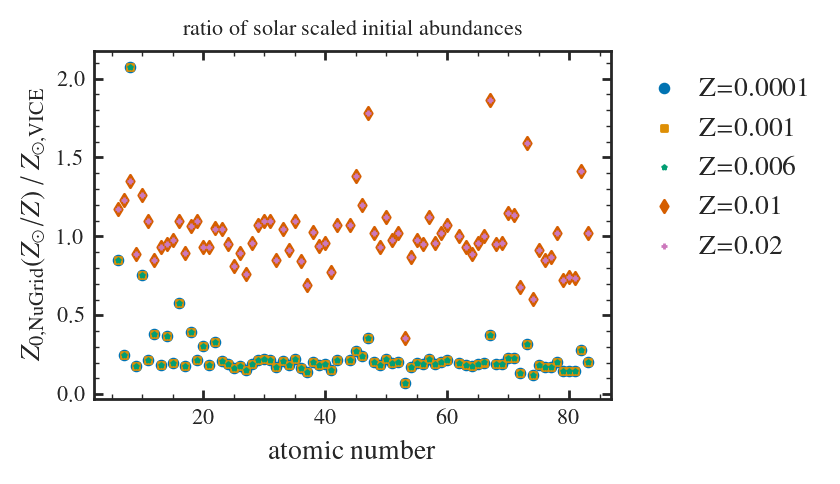

In [190]:


for (i, Z) in enumerate([0.0001, 0.001,0.006, 0.01, 0.02]):
    xs = []
    ys = []

    for ele in process_safe.elements[4:]:
        x = A(ele)
        y = z_ini(ele,Z) * 0.016/Z / vice.solar_z(ele)
    
        xs.append(x)
        ys.append(y)
        
    plt.scatter(xs, ys, label=f"Z={Z}", marker=["o", "s", "*", "d", "+"][i], s=2*[5, 3, 1, 5, 3][i])



plt.xlabel("atomic number")
plt.ylabel(r" $Z_{\rm 0, NuGrid} (Z_\odot/Z)$ / $Z_{\odot, \rm VICE}$ ")
plt.title("ratio of solar scaled initial abundances")
arya.Legend(-1)


(0.0001, 0.1)

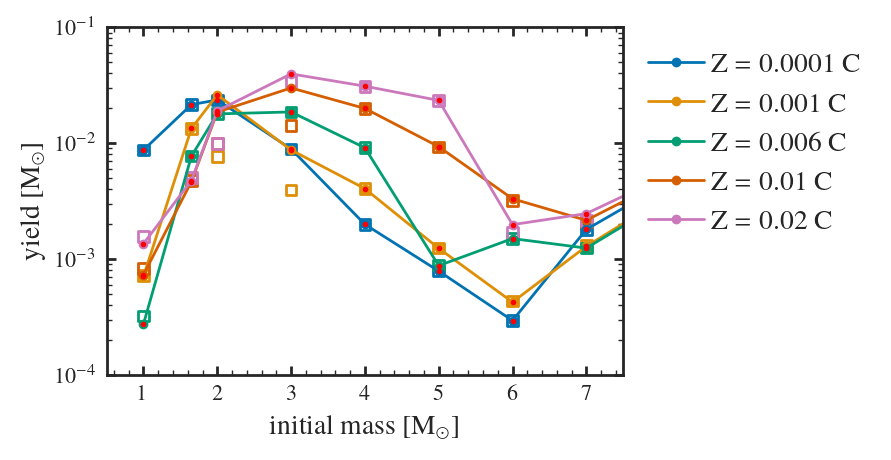

In [148]:
plot_all_yields("c")
plt.ylim(1e-4, 0.1)


(1e-05, 0.1)

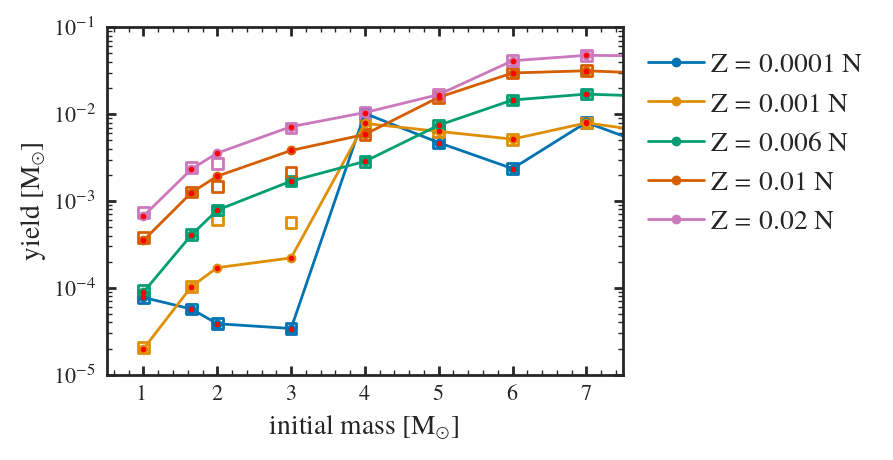

In [149]:
plot_all_yields("n")
plt.ylim(1e-5, 0.1)


(1e-05, 0.1)

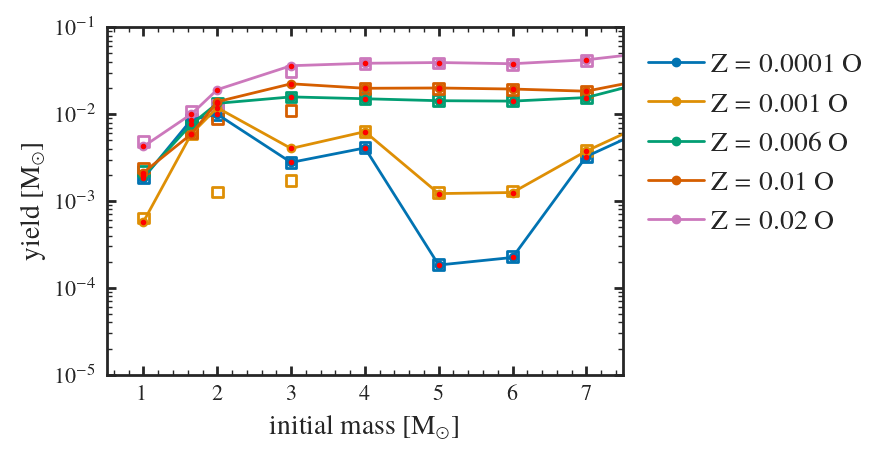

In [150]:
plot_all_yields("o")
plt.ylim(1e-5, 0.1)


(1e-10, 0.0001)

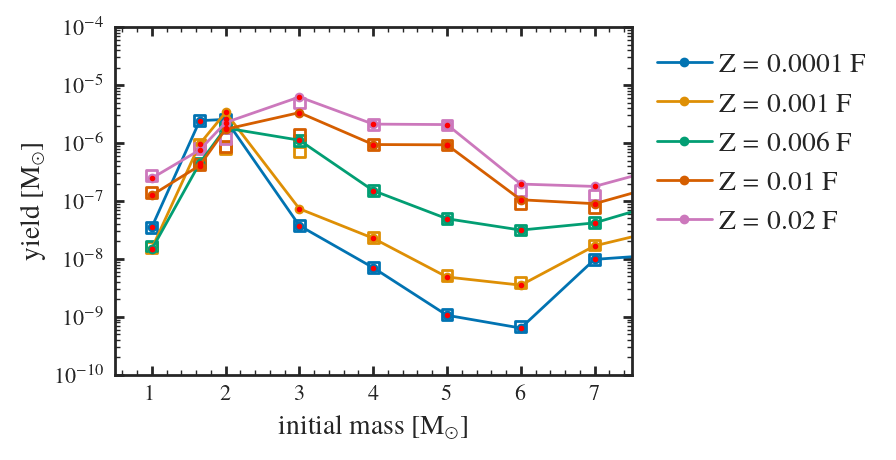

In [151]:
plot_all_yields("F")
plt.ylim(1e-10, 1e-4)

(1e-05, 0.03)

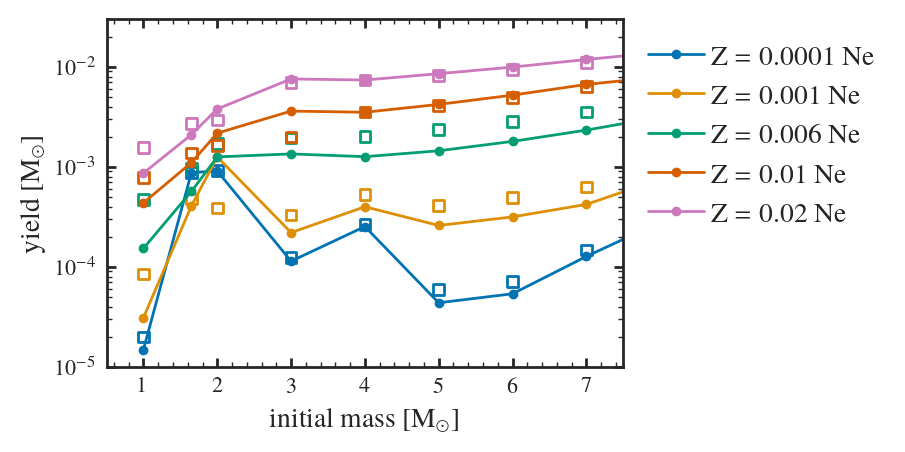

In [267]:
plot_all_yields("Ne")
plt.ylim(1e-5, 3e-2)

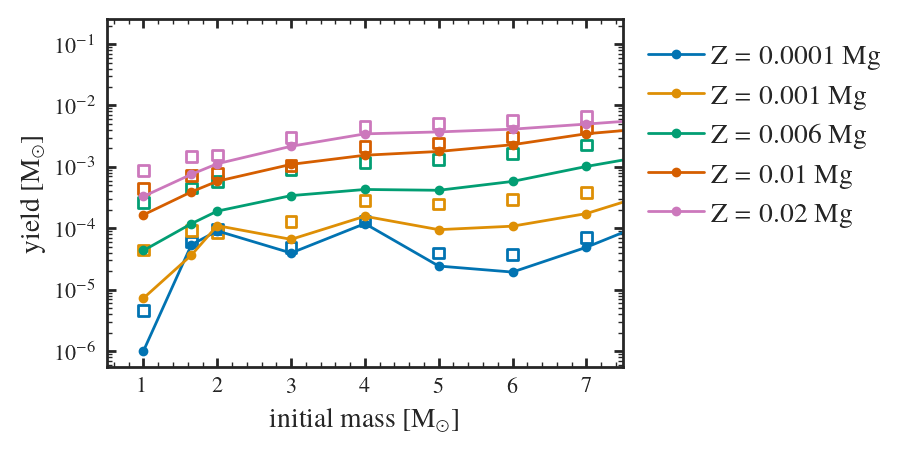

In [268]:
plot_all_yields("Mg")

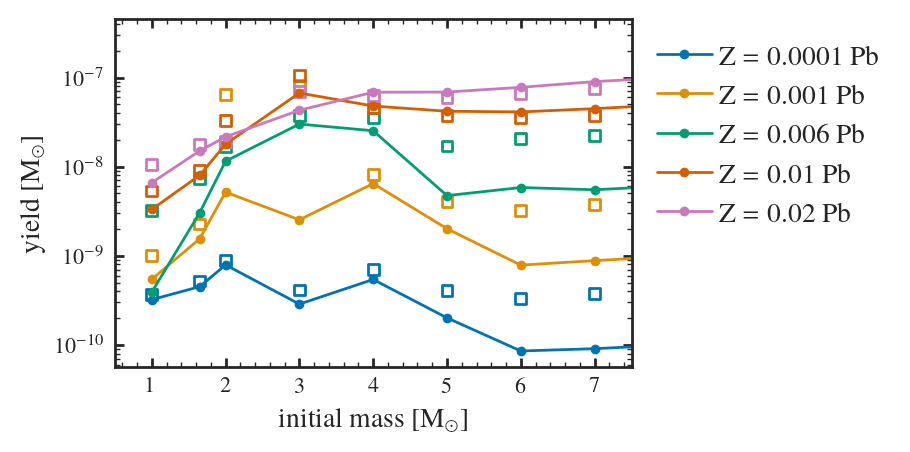

In [269]:
plot_all_yields("Pb")

# unecessary

In [10]:
def sygma_to_pd(s):
    dt = s.history.timesteps
    times = np.cumsum(dt)
    times = np.insert(times, 0, 0.)
    df = pd.DataFrame(s.history.ism_elem_yield, columns=s.history.elements)
    df["time"] = times

    return df

In [25]:
def run_sygma(ele="C", Z=0.01, table="pignatari16"):
    if table == "pignatari16":
        table = "yield_tables/agb_and_massive_stars_nugrid_MESAonly_fryer12rapid.txt"
    elif table == "pignatari16b":
        table = "yield_tables/agb_and_massive_stars_nugrid_N13.txt"
    elif table == "karakas10":
        table = "yield_tables/agb_and_massive_stars_K10_LC18_R000.txt"
    elif table == "cristallo11":
        table = "yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt"
    elif table == "karakas10b":
        table = "yield_tables/agb_and_massive_stars_K10_LC18_R300.txt"
    else:
        raise Exception("unknown table", table)
        
    s = sygma.sygma(iniZ=Z,
                table=table,
                    
                tend=10e9, mgal=1, ns_merger_on=False,
                sn1a_on=False,
                scale_cor = [[1.0, 8], [0., 100]]
               )

    return s

In [11]:
from vice.yields.agb import pignatari16

In [12]:
vice.yields.ccsne.settings["C"] = 0

In [13]:
def plot_vice(ele="C", Z=0.014, **kwargs):
    yields, times = vice.single_stellar_population(ele, Z=Z, time=10, mstar=1)

    times = [t*1e9 for t in times]
    plt.plot(times, yields, **kwargs)

In [14]:
def run_sygma(ele="C", Z=0.014, table="pignatari16"):
    if table == "pignatari16":
        table = "yield_tables/agb_and_massive_stars_nugrid_MESAonly_fryer12rapid.txt"
    elif table == "pignatari16b":
        table = "yield_tables/agb_and_massive_stars_nugrid_N13.txt"
    elif table == "karakas10":
        table = "yield_tables/agb_and_massive_stars_K10_LC18_R000.txt"
    elif table == "cristallo11":
        table = "yield_tables/agb_and_massive_stars_C15_LC18_R_mix.txt"
    elif table == "karakas10b":
        table = "yield_tables/agb_and_massive_stars_K10_LC18_R300.txt"
    else:
        raise Exception("unknown table", table)
        
    s = sygma.sygma(iniZ=Z,
                table=table,
                    
                tend=10e9, mgal=1, ns_merger_on=False,
                sn1a_on=False,
                scale_cor = [[1.0, 8], [0., 100]]
               )

    return s

In [30]:
def plot_sygma(ele="C", Z=0.014, table="pignatari16", **kwargs):

    s = run_sygma(ele, Z=Z, table=table)
    
    df = sygma_to_pd(s)

    t0 = 1e8
    idx0 = np.argmin(np.abs(df.time - t0))
    y = df[ele.title()]
    y -= y[idx0]
    plt.plot(df.time, df[ele.title()], **kwargs)


In [31]:
vice.yields.agb.grid("c", "pignatari16")[2]

(0.0001, 0.001, 0.006, 0.01, 0.02)

In [32]:
vice.yields.ccsne.settings["C"] = 0

In [33]:
kwargs_interp = dict(
    interp_kind="linear",
    min_mass=1,
    no_negative=False, 
)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


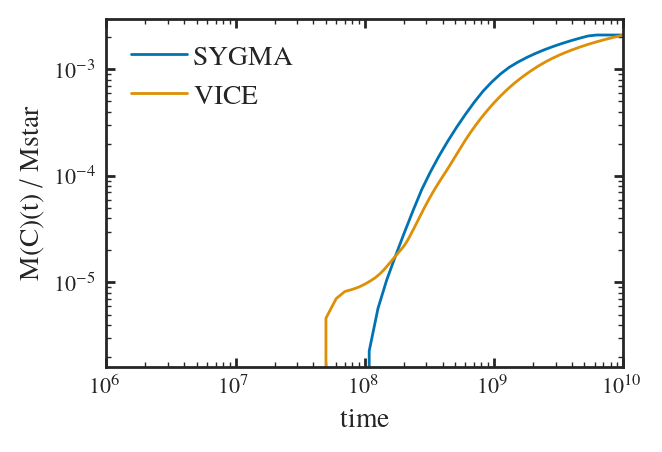

SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s


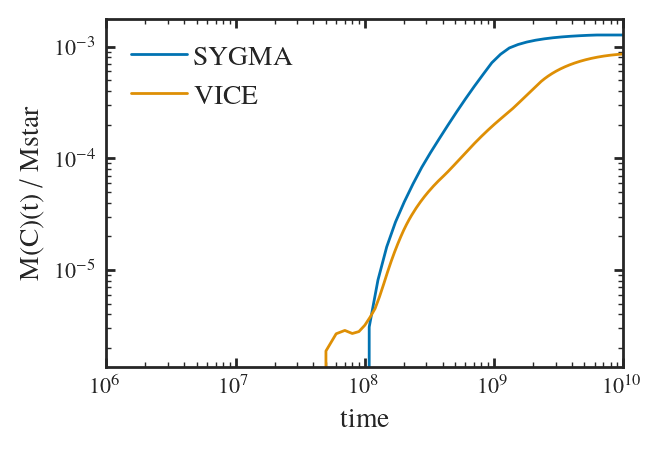

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


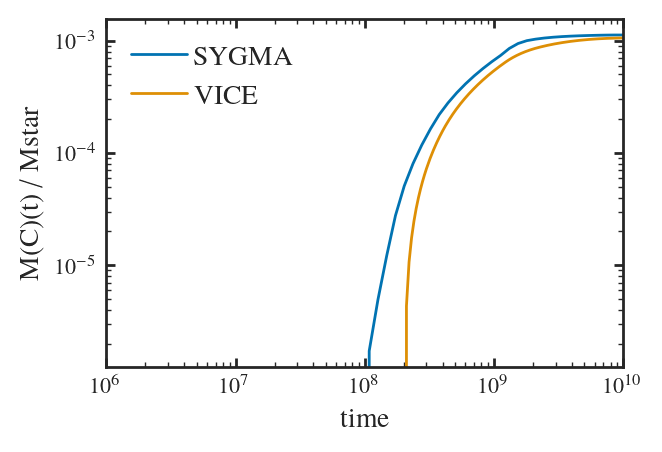

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


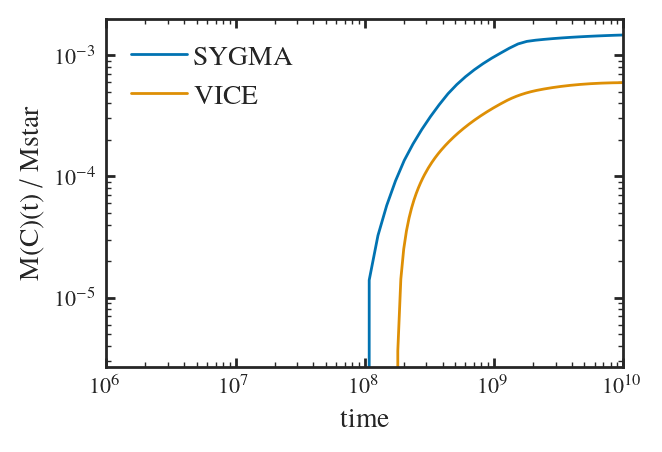

SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s


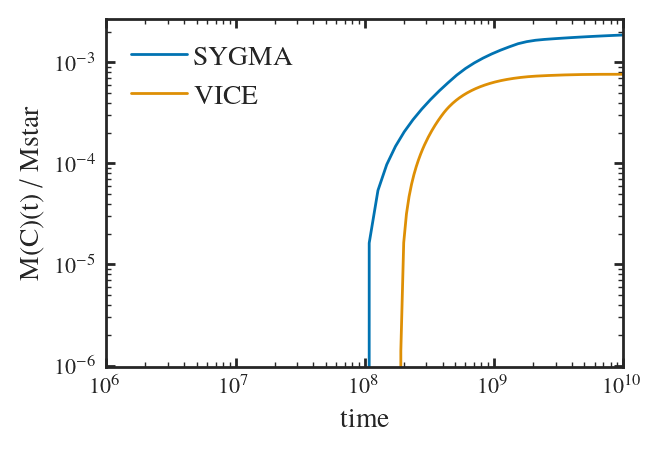

In [34]:
for Z in (0.0001, 0.001, 0.006, 0.01, 0.02):
    plot_sygma(Z=Z, label="SYGMA")
    plot_vice(Z=Z, label="VICE")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("time")
    plt.ylabel("M(C)(t) / Mstar")
    plt.xlim(1e6, 1e10)
    plt.legend()
    plt.show()

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/yields/agb/karakas10/__init__.py:46: ScienceWarning: The Karakas (2010) study did not report yields for elements heavier than nickel. AGB star yield settings for these elements will not be modified.
  warnings.warn("""\


SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


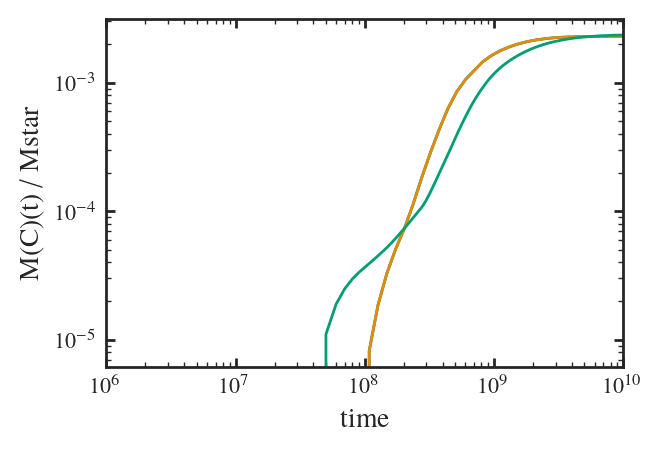

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


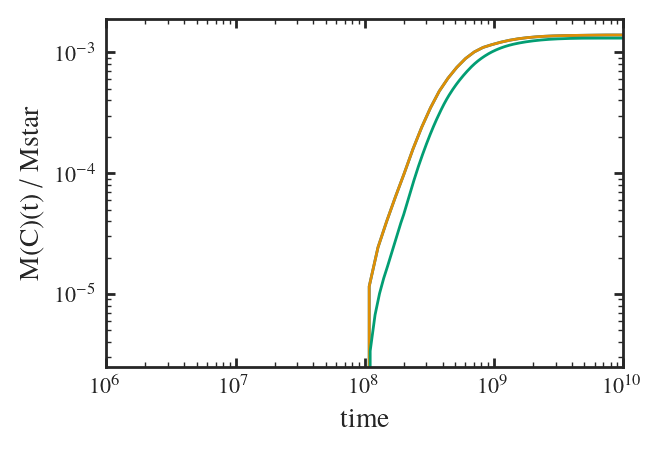

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


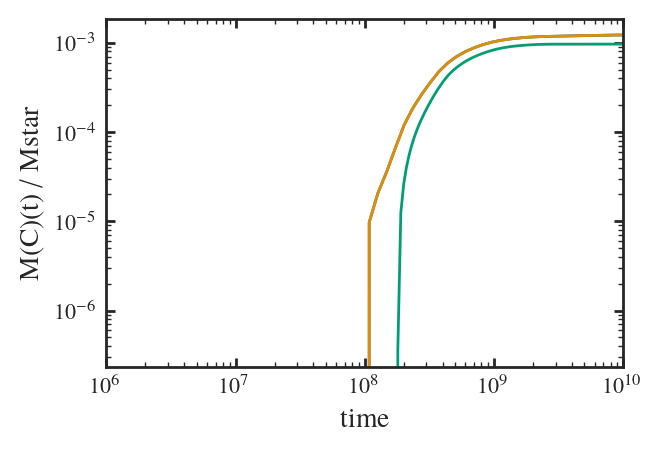

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


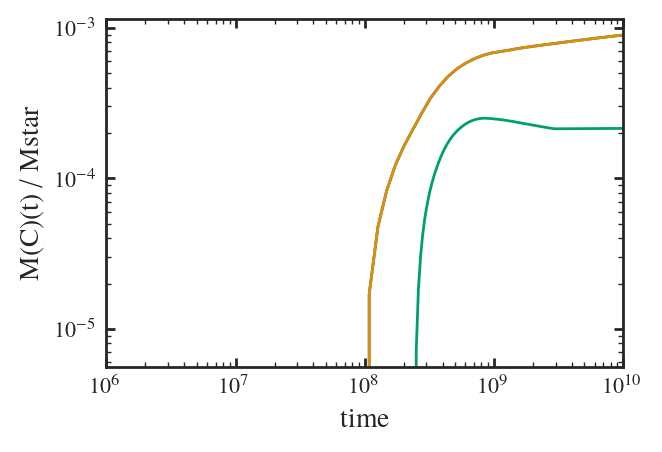

In [35]:
from vice.yields.agb import karakas10

for Z in (0.0001, 0.004, 0.008, 0.02):
    plot_sygma(Z=Z, table="karakas10")
    plot_sygma(Z=Z, table="karakas10b")

    plot_vice(Z=Z)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("time")
    plt.ylabel("M(C)(t) / Mstar")
    plt.xlim(1e6, 1e10)
    plt.show()

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


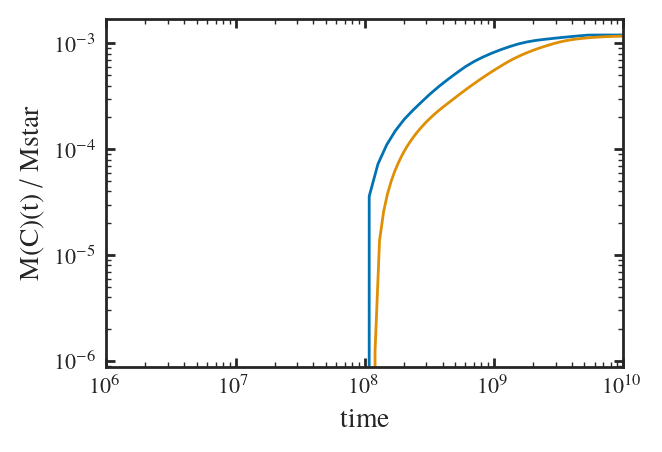

SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s


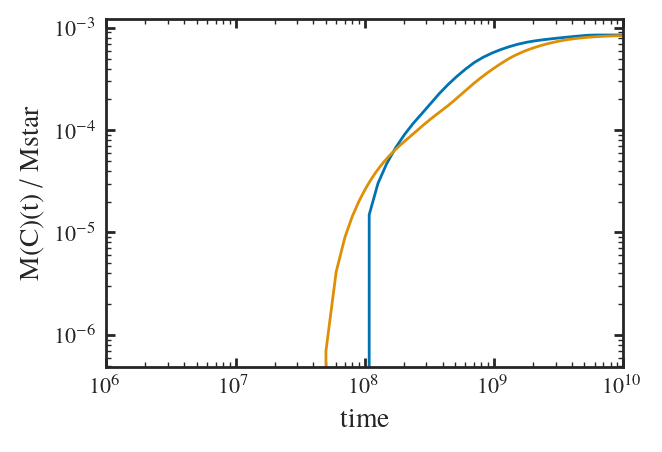

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


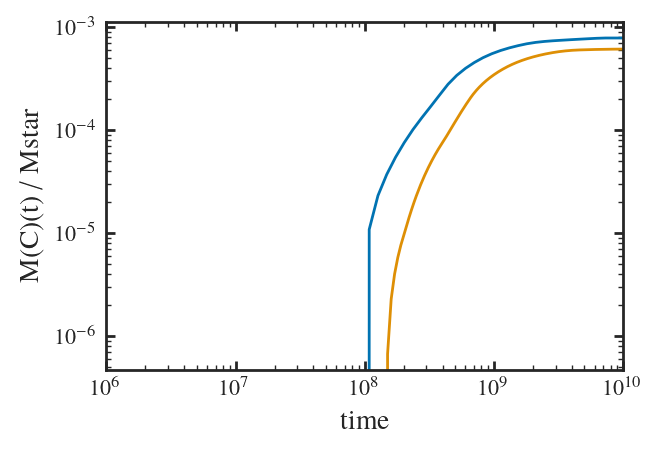

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


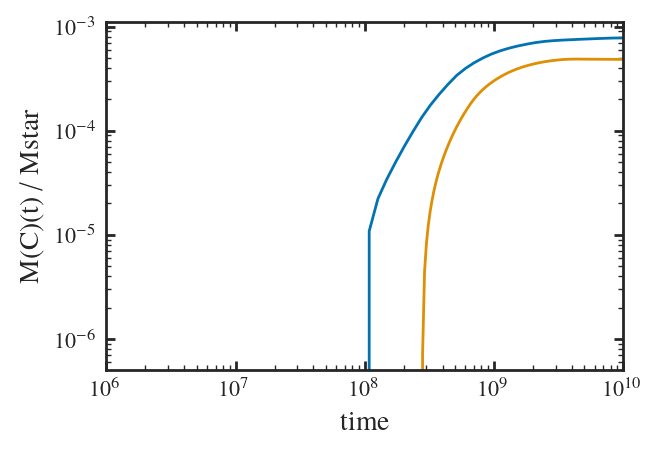

SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s


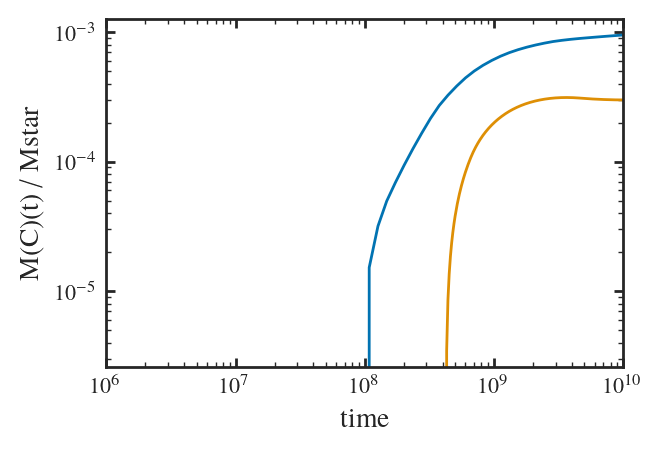

In [36]:
from vice.yields.agb import cristallo11

vice.yields.agb.settings["c"] = surp.agb_interpolator.interpolator("c", study = "cristallo11", **kwargs_interp
        )

for Z in (0.0001, 0.001, 0.006, 0.01, 0.02):
    plot_sygma(Z=Z, table="cristallo11")
    plot_vice(Z=Z)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("time")
    plt.ylabel("M(C)(t) / Mstar")
    plt.xlim(1e6, 1e10)
    plt.show()

In [37]:
s = run_sygma(Z=0.01)

SYGMA run in progress..
   SYGMA run completed - Run time: 0.06s


In [39]:
s.plot_table_param(quantity="Ekin_wind")

AttributeError: module 'NuPyCEE.read_yields' has no attribute 'read_nugrid_yields'

In [40]:
from NuPyCEE import read_yields

In [41]:
s.plot_table_remnant(iniZ=0.02)

AttributeError: module 'NuPyCEE.read_yields' has no attribute 'read_nugrid_yields'

In [42]:
s.plot_table_yield("mini", "C-12", 0.001)

IndexError: list index out of range

/astro/dboyea/source/NuPyCEE/sygma.py:2239: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=2,prop={'size':legend_fontsize})
/astro/dboyea/source/NuPyCEE/sygma.py:2245: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5),markerscale=0.8,fontsize=legend_fontsize)


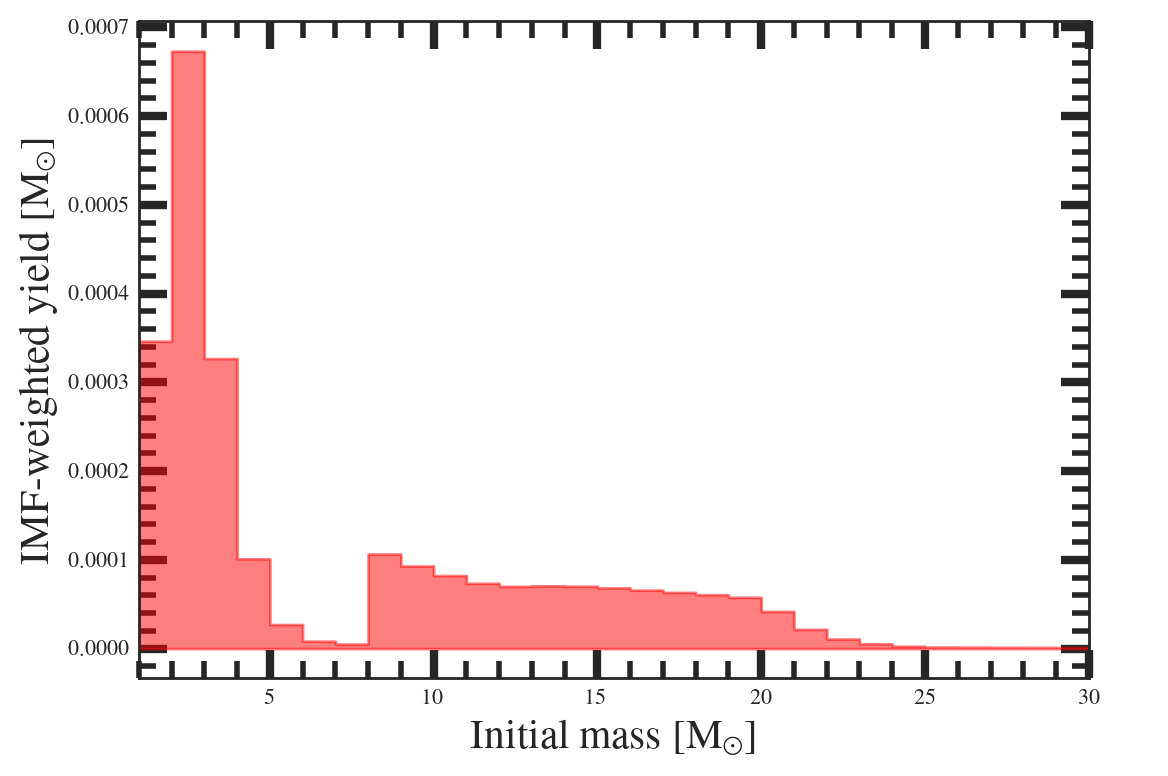

In [50]:
s.plot_mass_range_contributions("C")